In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
import nltk
#nltk.download('rslp')

In [7]:
df_original = pd.read_csv('./b2w.csv')
df_original.head()

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,11955,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0,4,1,1
1,35478,Produto excepcional! recomendo!!! inovador e ...,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0,5,1,1
2,122760,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0,1,1,1
3,17114,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0,5,1,1
4,19112,Além de higiênico tem o tamanho ideal. Só falt...,alem de higienico tem o tamanho ideal. so falt...,"['alem', 'de', 'higienico', 'tem', 'tamanho', ...",NaN,3,-1,1


In [3]:
def label_polarity(rating):
    if rating < 3:
        return 'negative'
    elif rating > 3:
        return 'positive'
    else:
        return 'neutral'

df = pd.DataFrame({'text': df_original["review_text"], 'polarity': df_original['rating'].apply(label_polarity)})
df.head()

,text,polarity
0,Bem macio e felpudo...recomendo. Preço imbatí...,positive
1,Produto excepcional! recomendo!!! inovador e ...,positive
2,recebi o produto antes do prazo mas veio com d...,negative
3,Bom custo beneficio. Adequado para pessoas que...,positive
4,Além de higiênico tem o tamanho ideal. Só falt...,neutral


In [4]:
df.polarity.value_counts()

positive    80300
negative    35758
neutral     16315
Name: polarity, dtype: int64

In [5]:
positive = df.query("polarity == 'positive'").sample(35000)
negative = df.query("polarity == 'negative'").sample(35000)
neutral = df.query("polarity == 'neutral'").sample(16000)
df = pd.concat([positive, negative])
df.polarity.value_counts()

positive    35000
negative    35000
Name: polarity, dtype: int64

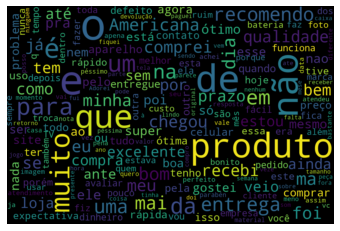

In [6]:
def show_wordcloud(dataframe: pd.DataFrame, column: str):
    all_words = ' '.join([ text for text in dataframe[column] ])
    word_cloud = WordCloud(width=1200, height=800, max_font_size=160, collocations=False).generate(all_words)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
show_wordcloud(df, "text")

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub("\d+", '', text)
    text = text.replace("\n", "")
    text = re.sub("https?://[A-Za-z0-9]*", ' ', text)
    return text

df["processed_text"] = df['text'].apply(preprocess_text)
df.head()

,text,polarity,processed_text
62150,Gostei muito do produto e chegou super rápido....,positive,gostei muito do produto e chegou super rápido....
21831,"TV COM DIVERSOS RECURSOS, DO JEITO QUE EU ESPE...",positive,"tv com diversos recursos, do jeito que eu espe..."
118234,"TV COM EXCELENTE QUALIDADE, SEM PROBLEMAS OU D...",positive,"tv com excelente qualidade, sem problemas ou d..."
120500,"Celular muito lindo, ótimo acabamento, bom de ...",positive,"celular muito lindo, ótimo acabamento, bom de ..."
109412,"Produto de exelente qualidade, realmente funci...",positive,"produto de exelente qualidade, realmente funci..."


In [8]:
def stemmizer(dataframe: pd.DataFrame, text_column: str):
    whitespace_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = nltk.RSLPStemmer()
    treated_data = []
    for review in dataframe[text_column]:
        tokenized_review = whitespace_tokenizer.tokenize(review)
        treated_review = []
        for word in tokenized_review:
            treated_review.append(stemmer.stem(word))
        treated_data.append(' '.join(treated_review))
    dataframe["treat_stem"] = treated_data
    
stemmizer(df, "processed_text")
df.head()

,text,polarity,processed_text,treat_stem
62150,Gostei muito do produto e chegou super rápido....,positive,gostei muito do produto e chegou super rápido....,gost muit do produt e cheg sup rápido. recomendo.
21831,"TV COM DIVERSOS RECURSOS, DO JEITO QUE EU ESPE...",positive,"tv com diversos recursos, do jeito que eu espe...","tv com divers recursos, do jeit que eu esperav..."
118234,"TV COM EXCELENTE QUALIDADE, SEM PROBLEMAS OU D...",positive,"tv com excelente qualidade, sem problemas ou d...","tv com excel qualidade, sem problem ou defeit ..."
120500,"Celular muito lindo, ótimo acabamento, bom de ...",positive,"celular muito lindo, ótimo acabamento, bom de ...","celul muit lindo, ótim acabamento, bom de memó..."
109412,"Produto de exelente qualidade, realmente funci...",positive,"produto de exelente qualidade, realmente funci...","produt de exel qualidade, real funciona. adeu ..."


In [9]:
stop_words = set(stopwords.words("portuguese"))
count_vectorizer = CountVectorizer(lowercase = False, max_features = 200)
bag_of_words = count_vectorizer.fit_transform(df["processed_text"])

In [10]:
x_train, x_test, y_train, y_test = \
    train_test_split(
        bag_of_words, 
        df["polarity"],
        stratify = df["polarity"],
        shuffle = True,
        random_state = 42
    )

In [11]:
first_analysis = LogisticRegression()
first_analysis.fit(x_train, y_train)
accuracy = first_analysis.score(x_test, y_test)
accuracy

0.8981142857142858

In [26]:
frase_nova = "Péssimo fone, apresentou defeito após apenas 3 meses de uso"
frase_nova_vectorizer = count_vectorizer.transform([frase_nova])
first_analysis.predict(frase_nova_vectorizer)

array(['negative'], dtype=object)

In [11]:
df_original['review_text'  null]

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\vinic\AppData\Local\Temp\ipykernel_16208\985276123.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  df_original['review_text' is null]
C:\Users\vinic\AppData\Local\Temp\ipykernel_16208\985276123.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  df_original['review_text' is null]
C:\Users\vinic\AppData\Local\Temp\ipykernel_16208\985276123.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  df_original['review_text' is null]


NameError: name 'null' is not defined